# Text Analysis

In this lab we'll do a short text analysis so that you start to become familiar with the packages and tools available to you in Python to work with text data. Nothing here will be very in-depth - it's supposed to be able to be completed in a short period of time after all. But, it will give you a starting point for your final assignment and projects, should you want to analyze text data.

## Data Science Question
In this short project, we're going to answer the question: *For each presidential inauguration, which word is most unique?* 

To do this, we'll use the text from each Inaugural address in American history and carry out a TF-IDF analysis.

Secondarily, we'll think about whether these words make sense in the context of the history at the time and visualize words uniqueness over the course of history.

# Part I : Setup & Data Wrangling

This lab uses a number of different functions across multiple packages. **Run the following code cell and take a look at each package we'll be using below. Make sure you understand what the package is used for. Be sure to familiarize yourself with anything that you're not yet familiar with.**

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd

# Import nltk package 
# NLTK provides support for a wide variety of text processing tasks: 
# tokenization, stemming, proper name identification, part of speech identification, etc. 
#   PennTreeBank word tokenizer 
#   English language stopwords
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# scikit-learn imports
#   TF-IDF Vectorizer that first removes widely used words in the dataset and then transforms test data
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# import re for regular expression
import re

## seaborn for plotting
import seaborn as sns
sns.set(font_scale=1.2, style="white")

# import matplotlib for plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
# set plotting size parameter
plt.rcParams['figure.figsize'] = (12, 5)

# improve resolution
%config InlineBackend.figure_format ='retina'

To get started on your text analysis using the `nltk` package, run the code below to **download the NLTK English tokenizer ('punkt'), stopwords of all languages ('stopwords') from `nltk`, and the inaugural dataset from `nltk` ('inaugural')**. To determine what code you'll need to do this, you can explore the `download` method [here](https://www.nltk.org/) or their book [here](http://www.nltk.org/book/).

In [15]:
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('inaugural')

Now that you have downloaded a few of the datasets you'll need, **import the `inaugural` dataset from `nltk.corpus`.**

In [3]:
from nltk.corpus import inaugural

In [4]:
assert inaugural

If all is working well, the following cell should display the files included in this dataset. 

In [38]:
# inaugural.fileids()

As you can see there is one file from each address. And, you'll note that the filename includes the year of each address. We'll want to use that address later, so **write code that extracts the year from each filename and stores it as a list. Assign this list to the variable `years`.**  


In [16]:
years = [file.split('-')[0] for file in inaugural.fileids()]
# years

In [7]:
assert len(years) == len(inaugural.fileids())
assert years[1] == '1793'

Let's take a look at one of these addresses. We'll pick a short one - Washington's *second* address. **Run the code below to take a look.**

In [8]:
# see Washington's Second Inaugural Address
inaugural.raw('1793-Washington.txt')

'Fellow citizens, I am again called upon by the voice of my country to execute the functions of its Chief Magistrate. When the occasion proper for it shall arrive, I shall endeavor to express the high sense I entertain of this distinguished honor, and of the confidence which has been reposed in me by the people of united America.\n\nPrevious to the execution of any official act of the President the Constitution requires an oath of office. This oath I am now about to take, and in your presence: That if it shall be found during my administration of the Government I have in any instance violated willingly or knowingly the injunctions thereof, I may (besides incurring constitutional punishment) be subject to the upbraidings of all who are now witnesses of the present solemn ceremony.\n\n \n'

You'll notice that there are some new line characters, as well as a colon, some commas, some periods. We're really only interested in the words though for TF-IDF, so let's remove all punctuation. **Write code that returns a list (`text`), where each element in the list includes the text as above, but with:
- punctuation removed 
- each word separated by a space
- all words are lower case (i.e. "Constitution" should be "constitution)

Assign this to the variable `text`.

Hint:
- First create a list `text` containing the raw text for each file id in `inaugural.fileids()`.
- For each piece of raw text in the list `text`, substitute punctuations with a a space `' '`. Check out the function `re.sub`. In Regular expression, `r'[^...]+'` indicates all raw characters **except for** the ones after the symbol `^`. `A-Za-z0-9` stands for all the characters we **WANT** to be included in the raw text: the uppercase letters (which we will convert to lowercase in the next step),lowercase letters and numbers. 
- Finally convert each piece of raw text in the list `text` to lowercase. Check out `str.lower`.

In [39]:
text = [inaugural.raw(file) for file in inaugural.fileids()]
text = [re.sub(r'[^A-Za-z0-9]', " ", raw_text).lower() for raw_text in text]
text

['fellow citizens of the senate and of the house of representatives   among the vicissitudes incident to life no event could have filled me with greater anxieties than that of which the notification was transmitted by your order  and received on the 14th day of the present month  on the one hand  i was summoned by my country  whose voice i can never hear but with veneration and love  from a retreat which i had chosen with the fondest predilection  and  in my flattering hopes  with an immutable decision  as the asylum of my declining years    a retreat which was rendered every day more necessary as well as more dear to me by the addition of habit to inclination  and of frequent interruptions in my health to the gradual waste committed on it by time  on the other hand  the magnitude and difficulty of the trust to which the voice of my country called me  being sufficient to awaken in the wisest and most experienced of her citizens a distrustful scrutiny into his qualifications  could not 

In [10]:
assert isinstance(text, list)
assert len(text) == 59
out = re.search('^fellow',text[0])
assert out != None

If you've done this correctly and you **run the following cell, all punctuation should be stripped from the text, so that you only see the words from Washington's second address, separated by spaces, with all words lowercase.**

In [11]:
text[1]

'fellow citizens  i am again called upon by the voice of my country to execute the functions of its chief magistrate  when the occasion proper for it shall arrive  i shall endeavor to express the high sense i entertain of this distinguished honor  and of the confidence which has been reposed in me by the people of united america   previous to the execution of any official act of the president the constitution requires an oath of office  this oath i am now about to take  and in your presence  that if it shall be found during my administration of the government i have in any instance violated willingly or knowingly the injunctions thereof  i may  besides incurring constitutional punishment  be subject to the upbraidings of all who are now witnesses of the present solemn ceremony     '

With that, you now have a dataset ready for analysis by TF-IDF!

# Part II : Text Analysis

To get started on your TF-IDF analysis, you'll first want to **create a `TfidfVectorizer` object to transform your text data into vectors. Assign this `TfidfVectorizer` object to `tfidf`.**

In this object, you'll need to **pass five arguments to initialize a `TfidfVectorizer`**: 
* set to apply TF scaling: `sublinear_tf=True`
* analyze at the word-level: `analyzer='word'`
* set maximum number of unique words: ` max_features=2000`
* specify that you want to tokenize the data using the word_tokenizer from NLTK: `tokenizer=word_tokenize`
* remove English language stop words: `stop_words=stopwords.words("english")`

In [12]:
tfidf = TfidfVectorizer(sublinear_tf=True,
                        analyzer='word',
                        max_features=2000,
                        tokenizer=word_tokenize,
                        stop_words=stopwords.words("english"))

In [13]:
assert tfidf.analyzer == 'word'
assert tfidf.max_features == 2000
assert tfidf.tokenizer == word_tokenize

Now, it's time to calculate TF-IDF for words across our corpus of Inaugural addresses! 

To do this:

1. Use the `tfidf.fit_transform` function to calculate TF-IDF on your `text` variable. Use `.toarray()` to transform the output to a numpy array named `tfidf_array`. 
2. Generate a DataFrame `inaug_tfidf` by passing `tfidf_array` into `pd.DataFrame`.
2. Be sure that the columns are named with the columns of the words the values represent and your index in `inaug_tfidf` is the year of the address. The `get_feature_names` method from `tfidf` may help you accomplish the columns name assignment. And the `years` you created earlier may help you with the indices.

In [18]:
tfidf_array = tfidf.fit_transform(text).toarray()
inaug_tfidf = pd.DataFrame(tfidf_array)
inaug_tfidf.index = years
inaug_tfidf.columns = tfidf.get_feature_names_out()
inaug_tfidf.head()

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,000,abandon,abiding,ability,able,abroad,absolute,abundant,abuses,accept,...,write,written,wrong,year,years,yes,yet,yield,young,zeal
1789,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.00000,0.000000,0.025474,0.0,0.000000,0.0,0.0,0.000000
1793,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,...,0.000000,0.000000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000
1797,0.0,0.000000,0.0,0.0,0.000000,0.033842,0.000000,0.0,0.043945,0.0,...,0.000000,0.000000,0.00000,0.051073,0.041101,0.0,0.000000,0.0,0.0,0.045604
1801,0.0,0.053954,0.0,0.0,0.000000,0.038474,0.051846,0.0,0.084591,0.0,...,0.053954,0.000000,0.06211,0.000000,0.000000,0.0,0.045778,0.0,0.0,0.051846
1805,0.0,0.000000,0.0,0.0,0.036267,0.000000,0.000000,0.0,0.071839,0.0,...,0.000000,0.040981,0.00000,0.049311,0.032016,0.0,0.038877,0.0,0.0,0.092403


In [19]:
assert len(inaug_tfidf.index) == len(years)
assert len(inaug_tfidf.columns) == 2000
assert inaug_tfidf.shape == (59, 2000)

# Part 3: Results

We're almost there. We now have a DataFrame that includes the TF-IDF for the top 2000 words in our corpus! **Now, you'll want to extract the single most unique word from each address. Assign this information (most likely a Series object) to the variable `most_unique`.**

Hint: you can use `pd.DataFrame.idxmax()` to find the column name with the maximum value for each row. Make sure you set the right `axis` parameter in this function so that you are looking for the **column name** with the maximum value, not the **index number**.

In [20]:
most_unique = inaug_tfidf.idxmax(axis=1)
most_unique

1789           article
1793           thereof
1797          virtuous
1801           trusted
1805             false
1809      improvements
1813           british
1817             naval
1821    fortifications
1825        instituted
1829         generally
1833        intentions
1837          supposed
1841             roman
1845             texas
1849            purity
1853          apparent
1857            whilst
1861          minority
1865            slaves
1869            dollar
1873       proposition
1877           dispute
1881             negro
1885          partisan
1889            ballot
1893          activity
1897             loans
1901           islands
1905             tasks
1909        interstate
1913           process
1917           counsel
1921      relationship
1925            stands
1929       enforcement
1933            helped
1937           despair
1941            speaks
1945           learned
1949           program
1953      productivity
1957           peoples
1961       

In [21]:
assert len(most_unique) == 59
assert most_unique.iloc[0] == 'article'
assert most_unique.iloc[-1] == 'story'

Take a look through this list of most unique words over time. Do they make sense based on what you know about American history? Do any surprise you?

With that part of our Analysis done, one thing that stuck out to me in this list is the fact that "british" was the most unique word to the 1813 inaugural address. This made sense to me - it was early in American history and we had only recently left British rule. But, I was curious to see whether or not 'british' would show up uniquely (albeit less uniquely) in any later addresses. **Generate a line plot that plots the TF-IDF value for the column name `'british'` on the y-axis. Plot year on the x-axis.**

Hint: you can use `plt.xticks(np.arange(0,75,step=5))` to make the x-axis look tidier.

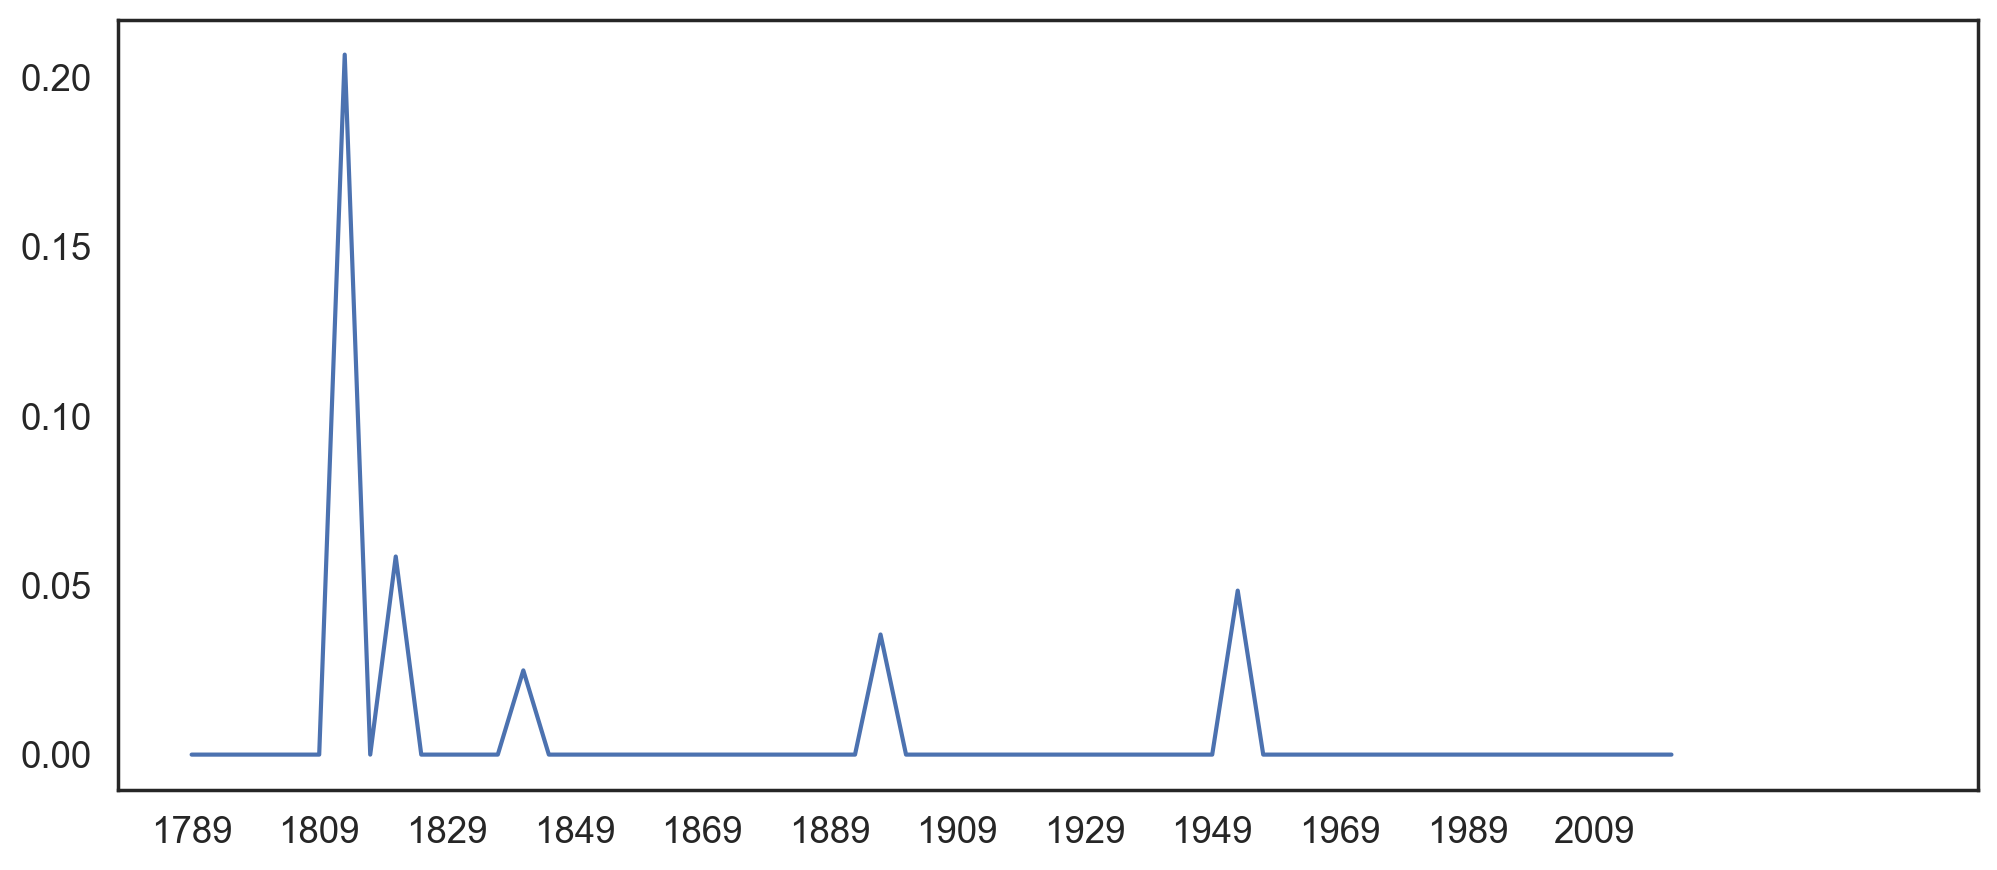

In [22]:
f1 = plt.gcf()
plt.plot(inaug_tfidf['british']);
plt.xticks(np.arange(0,75,step=5));

In [23]:
assert f1.gca().has_data()

Here you should see that over time "british" peaked in inaugural addresses at a few interesting points throughout history. What about some other words?

Using a similar approach, **plot the TF-IDF value for "british", "america", "war", and "jobs" on the y-axis and plot the years on the x-axis. Make sure to label each line. Take a look at the trends over time. Feel free to look at other words' trends over time.**

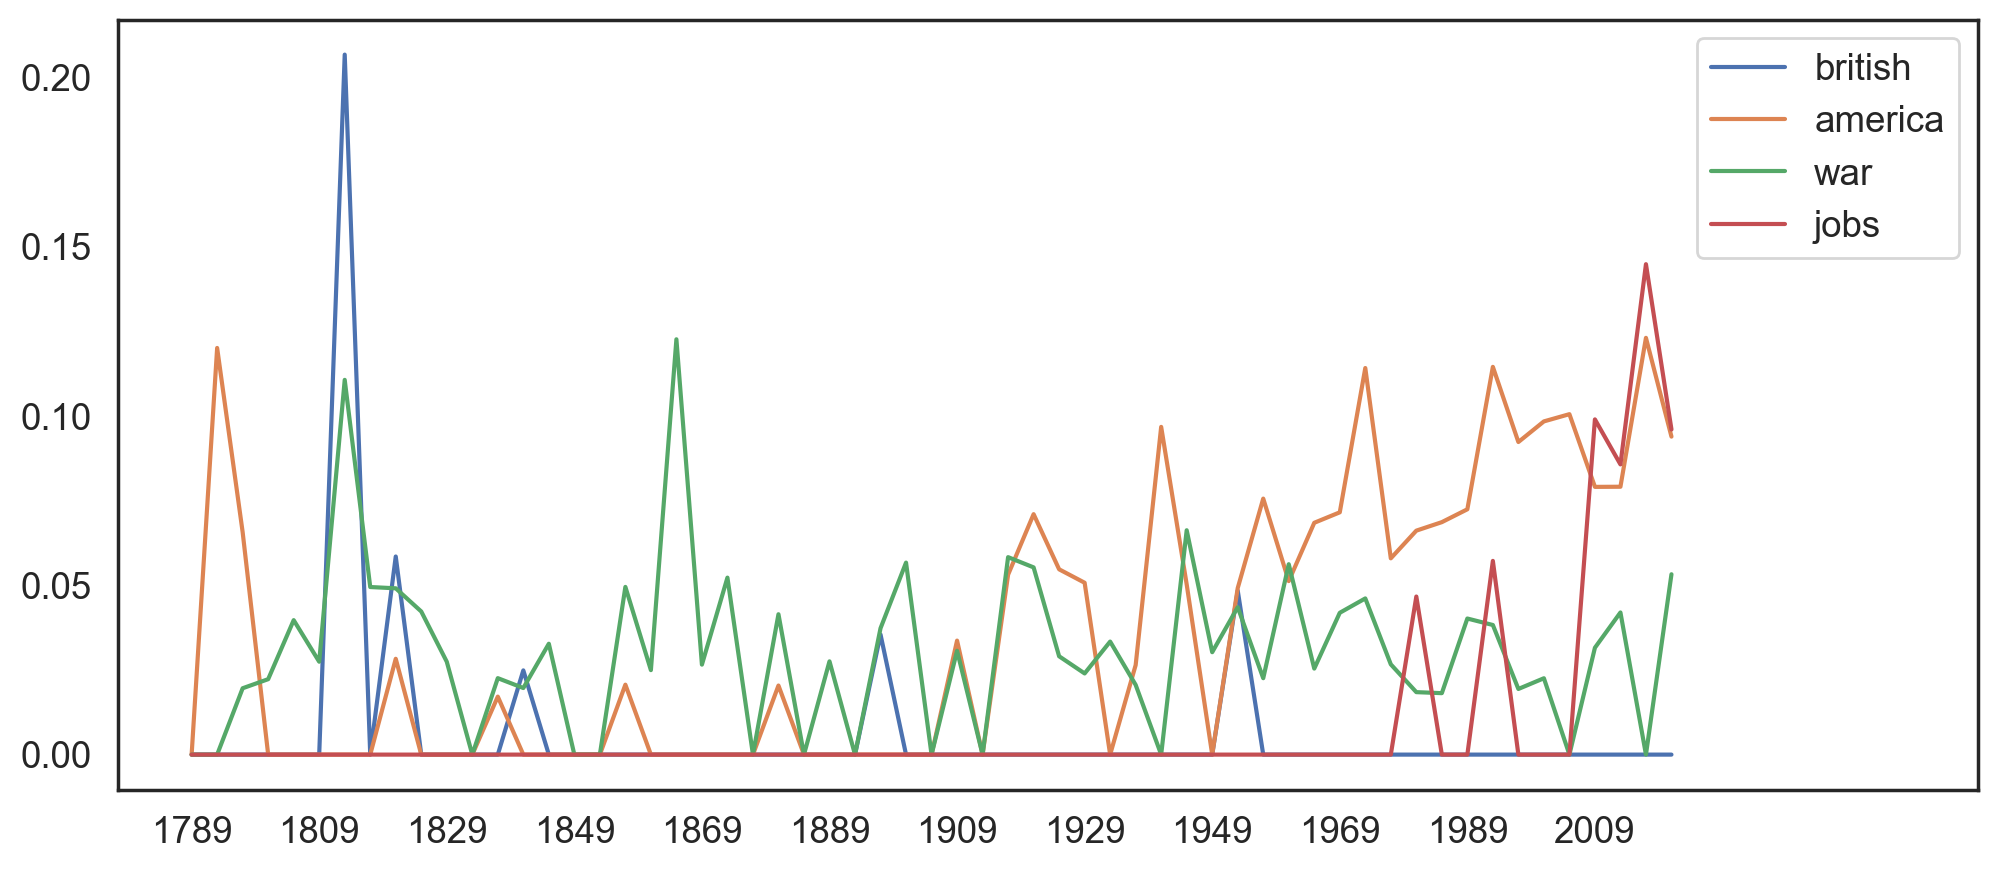

In [24]:
f2 = plt.gcf()
plt.plot(inaug_tfidf['british'], label='british');
plt.plot(inaug_tfidf['america'], label='america');
plt.plot(inaug_tfidf['war'], label='war');
plt.plot(inaug_tfidf['jobs'], label='jobs');
plt.xticks(np.arange(0,75,step=5));
plt.legend(loc='upper right');

In [25]:
assert f2.gca().has_data()

You should see that the mention of "america" happened frequently in the country's infancy, but then became less common, whereas "british was really common early on and "jobs" has really only become applicable in recent innaugural addresses.

As with all analysis, TF-IDF is not without its limitations. Let's take a look at how our results change if we change the `max_features` result in our analysis above to include 4000 words (rather than 2000). **Redo** the analysis to
1. Initiate a `TfidfVectorizer` object that takes in the same parameters as `tfidf`, except that `max_features = 4000`. Assign this object to the variable `tfidf2`.
2. Use `tfidf2` to calculate TF-IDF of the `text` list with the function `fit_transform`. Use `.toarray()` to convert the result to an array, and name the array `tfidf2_array`.
3. Create a `pd.DataFrame` called `inaug_tfidf2` using the array `tfidf2_array`. Again, make sure that your index in `inaug_tfidf2` is the year of the address and the columns are named with the columns of the words the values represent. 
4. Identify the most uniuqe words for each year from new model `inaug_tfidf2`, store the result in `most_unique_4000`.


Define a tfidfvectorizer object as `tfidf2`

In [26]:
# define tfidfvectorizer object as tfidf2
tfidf2 = TfidfVectorizer(sublinear_tf=True,
                         analyzer='word',
                         max_features=4000,
                         tokenizer=word_tokenize,
                         stop_words=stopwords.words("english")
                        )

In [27]:
assert tfidf2.max_features == 4000

In [29]:
# calculate TF-DF on input text, create the dataframe inaug_tfidf2.
tfidf2_array = tfidf2.fit_transform(text).toarray()
inaug_tfidf2 = pd.DataFrame(tfidf2_array)
inaug_tfidf2.index = years
inaug_tfidf2.columns = tfidf2.get_feature_names_out()

inaug_tfidf2.loc['2021'].sort_values().reset_index()
inaug_tfidf2['let']

c:\Users\bdion\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


1789    0.000000
1793    0.000000
1797    0.000000
1801    0.061796
1805    0.031007
1809    0.000000
1813    0.025064
1817    0.024677
1821    0.000000
1825    0.000000
1829    0.000000
1833    0.054814
1837    0.000000
1841    0.008772
1845    0.011759
1849    0.043661
1853    0.034560
1857    0.026906
1861    0.000000
1865    0.073821
1869    0.025214
1873    0.023862
1877    0.016599
1881    0.030767
1885    0.035599
1889    0.020795
1893    0.000000
1897    0.021924
1901    0.000000
1905    0.000000
1909    0.000000
1913    0.035792
1917    0.048654
1921    0.033110
1925    0.013345
1929    0.000000
1933    0.018720
1937    0.019853
1941    0.024938
1945    0.000000
1949    0.000000
1953    0.000000
1957    0.000000
1961    0.086736
1965    0.041108
1969    0.063656
1973    0.089949
1977    0.059694
1981    0.049897
1985    0.048316
1989    0.030199
1993    0.070367
1997    0.059968
2001    0.000000
2005    0.000000
2009    0.051420
2013    0.031172
2017    0.037605
2021    0.0503

In [30]:
assert list(inaug_tfidf2.index) == years
assert inaug_tfidf2.shape == (59,4000)

In [31]:
# identify most uniuqe word each year from new model, assign the result to most_unique_4000.
most_unique_4000 = inaug_tfidf2.idxmax(axis=1)
most_unique_4000

1789       immutable
1793     injunctions
1797        pleasing
1801          retire
1805      whatsoever
1809    improvements
1813         british
1817          trials
1821        colonies
1825     dissensions
1829      diffidence
1833       inculcate
1837        supposed
1841           roman
1845           texas
1849          purity
1853          hardly
1857          whilst
1861          secede
1865        offenses
1869          dollar
1873         domingo
1877         dispute
1881           negro
1885        partisan
1889          ballot
1893       frugality
1897           loans
1901            cuba
1905         regards
1909      interstate
1913        familiar
1917          wished
1921    relationship
1925      represents
1929      eighteenth
1933          helped
1937           paint
1941          speaks
1945         learned
1949           major
1953    productivity
1957         strives
1961           sides
1965        covenant
1969        rhetoric
1973            role
1977         

In [32]:
assert len(most_unique_4000) == 59
assert most_unique_4000.iloc[0] == 'immutable'
assert most_unique_4000.iloc[-1] == 'virus'

### Compare the Results
Join `most_unique` from the original model with this new list `most_unique_4000`
in a single dataframe to compare word each year. Name this dataframe `df_unique`.

Hint: you can use `pd.concat` to join two lists. Make sure to check the `axis` parameter so that the two lists are added as **two columns side by side**.

In [33]:
df_unique = pd.concat([most_unique, most_unique_4000], axis=1)
df_unique.head()

,0,1
1789,article,immutable
1793,thereof,injunctions
1797,virtuous,pleasing
1801,trusted,retire
1805,false,whatsoever


In [34]:
most_unique == df_unique[0]

1789    True
1793    True
1797    True
1801    True
1805    True
1809    True
1813    True
1817    True
1821    True
1825    True
1829    True
1833    True
1837    True
1841    True
1845    True
1849    True
1853    True
1857    True
1861    True
1865    True
1869    True
1873    True
1877    True
1881    True
1885    True
1889    True
1893    True
1897    True
1901    True
1905    True
1909    True
1913    True
1917    True
1921    True
1925    True
1929    True
1933    True
1937    True
1941    True
1945    True
1949    True
1953    True
1957    True
1961    True
1965    True
1969    True
1973    True
1977    True
1981    True
1985    True
1989    True
1993    True
1997    True
2001    True
2005    True
2009    True
2013    True
2017    True
2021    True
dtype: bool

In [35]:
assert df_unique.shape == (59,2)

for i in range(df_unique.shape[0]):
    assert (df_unique.iloc[i, 0] == most_unique.iloc[i]) or (df_unique.iloc[i, 1] == most_unique.iloc[i])

Regenerate the plot with the TF-IDF value for "british", "america", "war", and "jobs" on the y-axis and plot the years on the x-axis. Make sure to label each line.

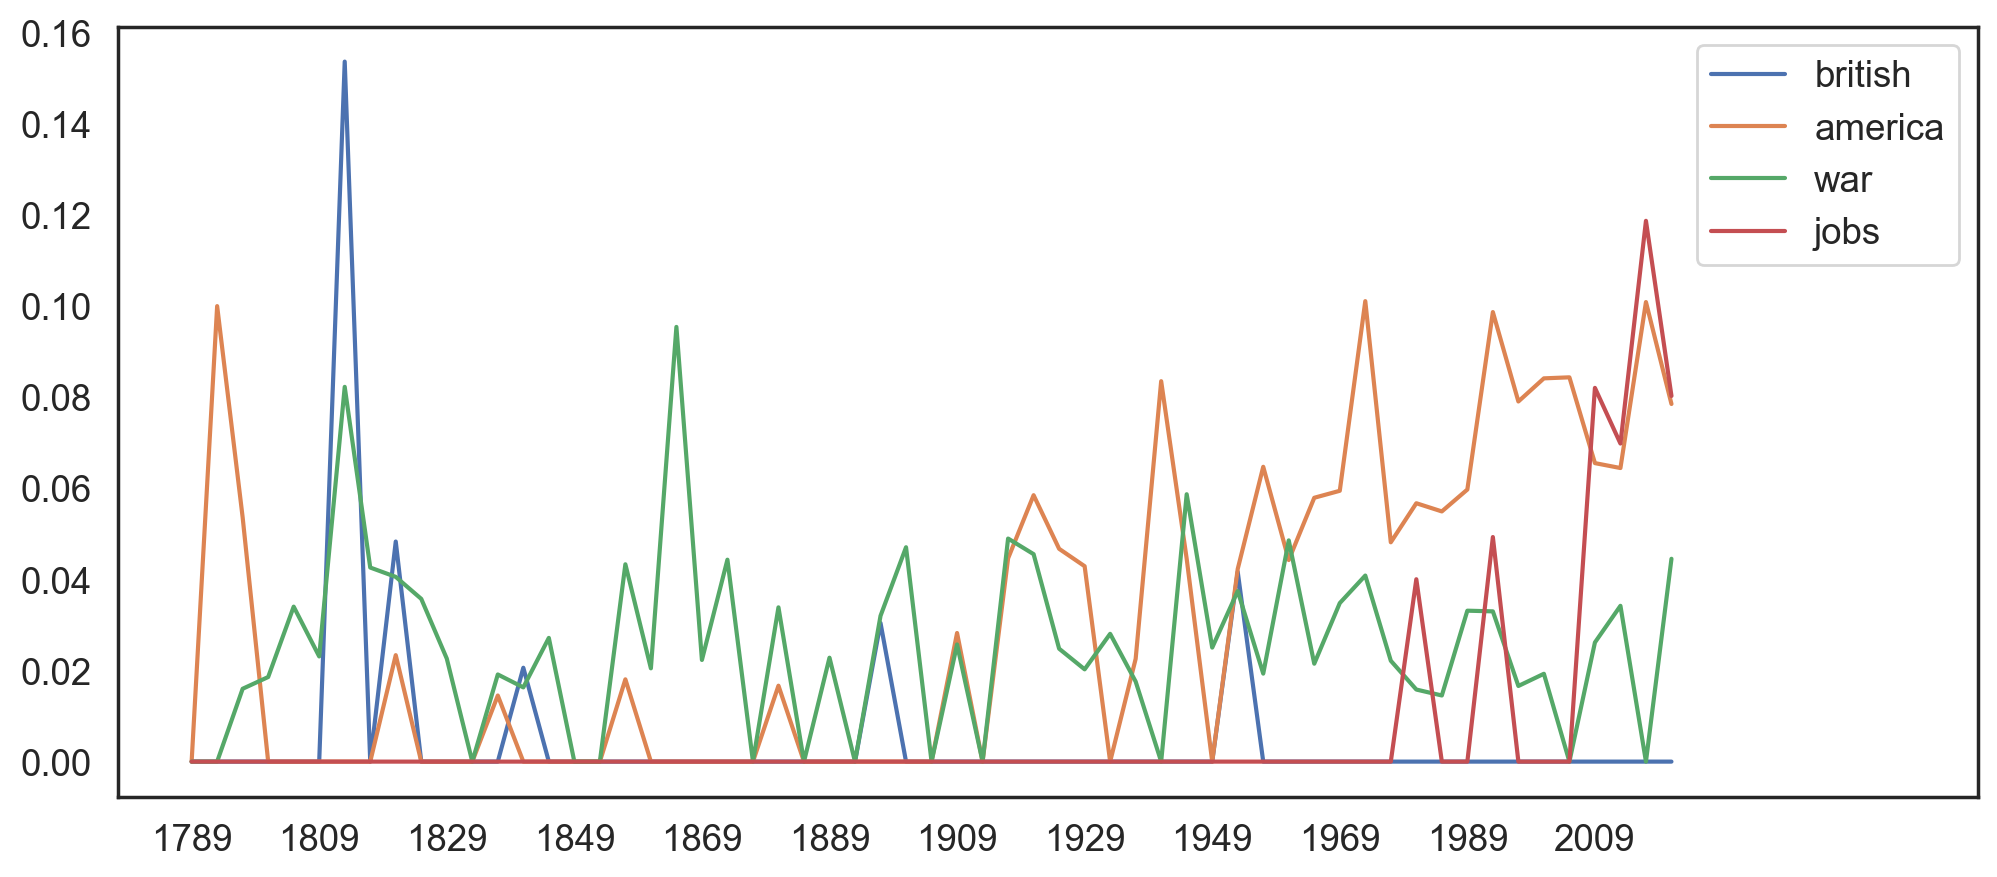

In [36]:
# regenerate plot
f3 = plt.gcf()
plt.plot(inaug_tfidf2['british'], label='british');
plt.plot(inaug_tfidf2['america'], label='america');
plt.plot(inaug_tfidf2['war'], label='war');
plt.plot(inaug_tfidf2['jobs'], label='jobs');
plt.xticks(np.arange(0,75,step=5));
plt.legend(loc='upper right');

In [37]:
assert f3.gca().has_data()

Good work getting comfortable working with text data here...and hopefully learning a bit more about Inaugural Addresses over time. Go ahead and submit your discussion lab!